In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os
from matplotlib.colors import ListedColormap
from tqdm import tqdm

class KohonenNetwork:
    def __init__(self, input_dim, grid_size=(10, 10), neighborhood_function='gaussian', 
                 neighborhood_width=1.0, learning_rate_decay=1000):
        self.input_dim = input_dim
        self.grid_size = grid_size
        self.M, self.N = grid_size
        
        self.weights = np.random.rand(self.M, self.N, input_dim) # inicjalizacja wag neuronów
        
        if neighborhood_function == 'gaussian': # dwie funkcje sąsiedztwa
            self.neighborhood_function = self._gaussian
        elif neighborhood_function == 'mexican_hat':
            self.neighborhood_function = self._mexican_hat
        else:
            raise ValueError("Funkcja sąsiedztwa musi być 'gaussian' lub 'mexican_hat'")
        
        self.neighborhood_width = neighborhood_width
        self.learning_rate_decay = learning_rate_decay
        
        self.neuron_positions = np.array([[(i, j) for j in range(self.N)] for i in range(self.M)])
    
    def _gaussian(self, distance, t):
        return np.exp(-(distance * self.neighborhood_width) ** 2 / 2)
    
    def _mexican_hat(self, distance, t): # druga pochodna funkcji gaussowskiej
        dist_squared = (distance * self.neighborhood_width) ** 2
        return (1 - dist_squared) * np.exp(-dist_squared / 2)
    
    def _learning_rate(self, t):
        return np.exp(-t / self.learning_rate_decay)
    
    def _find_bmu(self, x):
        distances = np.sum((self.weights - x) ** 2, axis=2) # odległość euklidesowa
        bmu_idx = np.unravel_index(np.argmin(distances), distances.shape) # indeks neuronu o najmniejszej odległości
        return bmu_idx
    
    def train(self, data, epochs=100, verbose=True):
        n_samples = data.shape[0]
        
        for epoch in tqdm(range(epochs), desc="Trening sieci", unit="epoka"):
            
            indices = np.random.permutation(n_samples) # przetasowanie danych
            
            for idx in indices:
                x = data[idx]
                bmu = self._find_bmu(x)
                grid_dist = np.sum((self.neuron_positions - np.array(bmu)) ** 2, axis=2) ** 0.5
                learning_rate = self._learning_rate(epoch)
                neighborhood = self.neighborhood_function(grid_dist, epoch)
                update = learning_rate * neighborhood[:, :, np.newaxis] * (x - self.weights)
                self.weights += update
    
    def map_input(self, x):
        return self._find_bmu(x)
    
    def get_mapped_data(self, data):
        return np.array([self.map_input(x) for x in data])
    
    def visualize_map(self, data=None, labels=None, title="Siec Kohonena", ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        
        if data is not None and labels is not None:
            mapped_data = self.get_mapped_data(data)
            unique_labels = np.unique(labels)
            grid_labels = np.zeros((self.M, self.N))
            grid_counts = np.zeros((self.M, self.N))
            
            for data_idx, (i, j) in enumerate(mapped_data):
                label = labels[data_idx]
                grid_labels[i, j] += label
                grid_counts[i, j] += 1
            
            neuron_classes = np.zeros((self.M, self.N))
            for i in range(self.M):
                for j in range(self.N):
                    if grid_counts[i, j] > 0:
                        neuron_classes[i, j] = grid_labels[i, j] / grid_counts[i, j]
                    else:
                        neuron_classes[i, j] = -1  # Ustawienie wartości -1 dla pustych neuronów
            
            cmap = plt.cm.get_cmap('viridis', len(unique_labels))
            masked_data = np.ma.masked_where(grid_counts == 0, neuron_classes)
            im = ax.imshow(masked_data, cmap=cmap, interpolation='nearest', 
                          vmin=np.min(unique_labels), vmax=np.max(unique_labels))
            
            for i in range(self.M):
                for j in range(self.N):
                    if grid_counts[i, j] > 0:
                        ax.text(j, i, str(int(grid_counts[i, j])), 
                               ha="center", va="center", color="white", fontsize=8)
            
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label("Dominująca klasa")
            
            for i in range(self.M + 1):
                ax.axhline(i - 0.5, color='k', linestyle='-', alpha=0.3)
            for j in range(self.N + 1):
                ax.axvline(j - 0.5, color='k', linestyle='-', alpha=0.3)
            
            if len(unique_labels) <= 10: # Ograniczenie do 10 klas
                scatter_points = {}
                for label in unique_labels:
                    scatter_points[label] = [[], []]
                
                for data_idx, (i, j) in enumerate(mapped_data):
                    label = labels[data_idx]
                    scatter_points[label][0].append(j) 
                    scatter_points[label][1].append(i)
                
                markers = ['o', 's', '^', 'D', 'p', '*', 'x', '+', 'v', '>']
                for idx, (label, (x, y)) in enumerate(scatter_points.items()):
                    marker = markers[idx % len(markers)]
                    ax.scatter(x, y, marker=marker, s=30, 
                              facecolors='none', edgecolors='black', 
                              alpha=0.7, label=f"Klasa {label}")
                ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
            
        else:
            for i in range(self.M):
                for j in range(self.N):
                    ax.plot(j, i, 'ko', markersize=8)
            
            for i in range(self.M):
                for j in range(self.N):
                    if i < self.M - 1:
                        ax.plot([j, j], [i, i+1], 'k-', alpha=0.3)
                    if j < self.N - 1:
                        ax.plot([j, j+1], [i, i], 'k-', alpha=0.3)
        
        ax.set_title(title)
        ax.set_xlim(-0.5, self.N - 0.5)
        ax.set_ylim(self.M - 0.5, -0.5)
        ax.set_aspect('equal')
        
        ax.set_xlabel("Kolumna neuronu")
        ax.set_ylabel("Wiersz neuronu")
        
        return ax
    
    def analyze_clustering(self, data, labels):
        mapped_data = self.get_mapped_data(data)
        unique_labels = np.unique(labels)
        neuron_class_counts = {}
        
        for i in range(self.M):
            for j in range(self.N):
                neuron_class_counts[(i, j)] = {label: 0 for label in unique_labels}
        
        for data_idx, (i, j) in enumerate(mapped_data):
            label = labels[data_idx]
            neuron_class_counts[(i, j)][label] += 1
        
        neurons_with_mixed_classes = 0
        neurons_with_data = 0
        
        for (i, j), class_counts in neuron_class_counts.items():
            if sum(class_counts.values()) > 0:
                neurons_with_data += 1
                classes_in_neuron = sum(1 for count in class_counts.values() if count > 0)
                if classes_in_neuron > 1:
                    neurons_with_mixed_classes += 1
        
        neuron_coords = []
        for (i, j), class_counts in neuron_class_counts.items():
            if sum(class_counts.values()) > 0:
                neuron_coords.append((i, j))
        
        if not neuron_coords:
            clusters = []
        else:
            neuron_coords = np.array(neuron_coords)
            visited = set()
            clusters = []
            
            for idx, (i, j) in enumerate(neuron_coords):
                if (i, j) in visited:
                    continue
                
                cluster = [(i, j)]
                visited.add((i, j))
                
                stack = [(i, j)]
                while stack:
                    x, y = stack.pop()
                    neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
                    
                    for nx, ny in neighbors:
                        if (nx, ny) in neuron_class_counts and (nx, ny) not in visited:
                            if sum(neuron_class_counts[(nx, ny)].values()) > 0:
                                cluster.append((nx, ny))
                                visited.add((nx, ny))
                                stack.append((nx, ny))
                
                clusters.append(cluster)
        
        clusters_match_classes = len(clusters) == len(unique_labels)
        class_positions = {label: np.zeros(2) for label in unique_labels}
        class_counts = {label: 0 for label in unique_labels}
        
        for data_idx, (i, j) in enumerate(mapped_data):
            label = labels[data_idx]
            class_positions[label] += np.array([i, j])
            class_counts[label] += 1
        
        for label in unique_labels:
            if class_counts[label] > 0:
                class_positions[label] /= class_counts[label]
        neuron_stats = {}
        for (i, j), class_counts in neuron_class_counts.items():
            total = sum(class_counts.values())
            if total > 0:
                dominant_class = max(class_counts.items(), key=lambda x: x[1])[0]
                purity = class_counts[dominant_class] / total
                neuron_stats[(i, j)] = {
                    'total_samples': total,
                    'class_counts': class_counts,
                    'dominant_class': dominant_class,
                    'purity': purity
                }
        
        return {
            'num_clusters': len(clusters),
            'num_classes': len(unique_labels),
            'clusters_match_classes': clusters_match_classes,
            'neurons_with_mixed_classes': neurons_with_mixed_classes,
            'neurons_with_data': neurons_with_data,
            'mixed_classes_percentage': neurons_with_mixed_classes / neurons_with_data if neurons_with_data > 0 else 0,
            'class_positions': class_positions,
            'neuron_stats': neuron_stats,
            'clusters': clusters
        }
    
    def visualize_weight_planes(self, ax=None): # aby ladnie wyswietlic wagi neuronow
        if ax is None:
            nrows = int(np.ceil(self.input_dim / 2))
            fig, axes = plt.subplots(nrows, 2, figsize=(12, 3 * nrows))
            axes = axes.flatten()
        else:
            nrows = int(np.ceil(self.input_dim / 2))
            ncols = 2
            if self.input_dim == 1:
                axes = [ax]
            else:
                axes = np.array(ax).flatten()
        
        for i in range(self.input_dim):
            if i < len(axes):
                weight_plane = self.weights[:, :, i]
                im = axes[i].imshow(weight_plane, cmap='viridis', interpolation='nearest')
                axes[i].set_title(f"Wymiar {i+1}")
                plt.colorbar(im, ax=axes[i])
                
                for row in range(self.M + 1):
                    axes[i].axhline(row - 0.5, color='k', linestyle='-', alpha=0.3)
                for col in range(self.N + 1):
                    axes[i].axvline(col - 0.5, color='k', linestyle='-', alpha=0.3)
        
        if ax is None:
            for i in range(self.input_dim, len(axes)):
                axes[i].axis('off')
            
            plt.tight_layout()
        return axes



## Funkcje pomocnicze

In [2]:
def load_and_prepare_data(file_path, dimensions):
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Plik {file_path} nie istnieje.")
        try:
            data = pd.read_csv(file_path)
            if 'x' in data.columns and 'y' in data.columns:
                feature_cols = ['x', 'y']
                if dimensions == 3 and 'z' in data.columns:
                    feature_cols.append('z')
                
                X = data[feature_cols].values
                y = data['c'].values
                scaler = MinMaxScaler()
                X_scaled = scaler.fit_transform(X)
                
                return X_scaled, y
            
        except Exception as e:
            print(f"Próba wczytania nie powiodła się: {e}")
            
        data = pd.read_csv(file_path, header=None)
        X = data.iloc[:, :dimensions].values
        y = data.iloc[:, -1].values
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        return X_scaled, y
        
    except Exception as e:
        print(f"Błąd podczas wczytywania danych: {e}")
        return None, None

def test_kohonen_network(data_path, dimensions, grid_size=(10, 10), neighborhood_function='gaussian',
                        neighborhood_widths=[0.1, 1.0, 5.0, 10.0], epochs=100):

    X, y = load_and_prepare_data(data_path, dimensions)
    
    n_widths = len(neighborhood_widths)
    fig_map, axes_map = plt.subplots(1, n_widths, figsize=(5 * n_widths, 5))
    if n_widths == 1:
        axes_map = [axes_map]
    
    fig_weights = []
    axes_weights = []
    
    for width_idx, width in enumerate(neighborhood_widths):
        print(f"\nTestowanie sieci z funkcją sąsiedztwa {neighborhood_function} i szerokością {width}")
        
        network = KohonenNetwork(
            input_dim=dimensions,
            grid_size=grid_size,
            neighborhood_function=neighborhood_function,
            neighborhood_width=width,
            learning_rate_decay=1000
        )
        
        network.train(X, epochs=epochs)
        
        network.visualize_map(
            data=X,
            labels=y,
            title=f"{neighborhood_function}, width={width}",
            ax=axes_map[width_idx]
        )
        
        # Wizualizacja płaszczyzn wag na osobnej figurze
        fig_w, axes_w = plt.subplots(1, dimensions, figsize=(5 * dimensions, 5))
        if dimensions == 1:
            axes_w = [axes_w]
        network.visualize_weight_planes(axes_w)
        fig_w.suptitle(f"Płaszczyzny wag - {neighborhood_function}, szerokość={width}")
        fig_weights.append(fig_w)
        axes_weights.append(axes_w)
        
        # Analiza klastrowania
        analysis = network.analyze_clustering(X, y)
        
        print(f"Liczba klastrów: {analysis['num_clusters']}")
        print(f"Liczba klas: {analysis['num_classes']}")
        print(f"Czy liczba klastrów odpowiada liczbie klas: {analysis['clusters_match_classes']}")
        print(f"Procent neuronów z mieszanymi klasami: {analysis['mixed_classes_percentage']:.2%}")
        
        print("\nŚrednie pozycje neuronów dla poszczególnych klas:")
        for label, position in analysis['class_positions'].items():
            print(f"Klasa {label}: {position}")
        
        print("\nWybrane statystyki neuronów:")
        neuron_stats = list(analysis['neuron_stats'].items())
        if neuron_stats:
            for (i, j), stats in sorted(neuron_stats[:5]):  # Wyświetl tylko 5 pierwszych neuronów
                print(f"Neuron ({i}, {j}):")
                print(f"  Liczba próbek: {stats['total_samples']}")
                print(f"  Liczba próbek z poszczególnych klas: {stats['class_counts']}")
                print(f"  Dominująca klasa: {stats['dominant_class']}")
                print(f"  Czystość: {stats['purity']:.2%}")
    
    fig_map.suptitle(f"Mapa Kohonena - {neighborhood_function}")
    fig_map.tight_layout()
    plt.show()
    
    # Wyświetlenie figur z płaszczyznami wag
    for fig in fig_weights:
        fig.tight_layout()
        plt.show()

# Testy

## Hexagon

Najpierw sprawdzimy jak wyglądają dane wejściowe - powinny być w kształcie sześciokąta

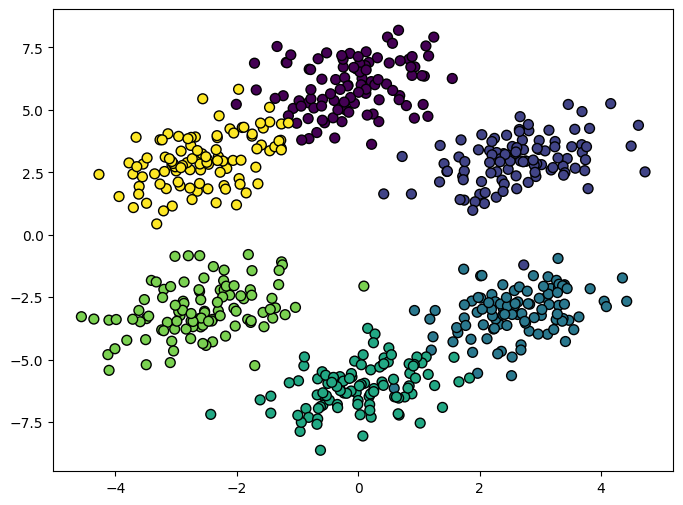

In [3]:
hexagon_path = "data/hexagon.csv"
data = pd.read_csv(hexagon_path, header=1).values
classes = data[:, 2]
data = data[:, :2]

# plot
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=classes, cmap='viridis', edgecolor='k', s=50)

Jak widać, jest 6 klas każda wokół jednego z 6 wierzchołków


Testowanie sieci z funkcją sąsiedztwa gaussian i szerokością 0.1


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 39.78epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


Liczba klastrów: 6
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: True
Procent neuronów z mieszanymi klasami: 12.00%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [9. 9.]
Klasa 1: [8.84 8.98]
Klasa 2: [0.  4.8]
Klasa 3: [0. 0.]
Klasa 4: [0. 0.]
Klasa 5: [8.33 6.93]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 222
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 21, np.int64(3): 100, np.int64(4): 100, np.int64(5): 1}
  Dominująca klasa: 3
  Czystość: 45.05%
Neuron (0, 3):
  Liczba próbek: 4
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 4, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 2
  Czystość: 100.00%
Neuron (0, 4):
  Liczba próbek: 9
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 9, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 2
  Czystość: 100.00%
Neuron (0, 5):
  Liczba próbek: 15
 

Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 39.37epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 6 Axes> than <Figure size 1000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 7.29%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [3.12 0.69]
Klasa 1: [7.34 1.51]
Klasa 2: [8.42 4.89]
Klasa 3: [5.38 8.11]
Klasa 4: [1.24 7.07]
Klasa 5: [0.75 3.01]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 4
  Liczba próbek z poszczególnych klas: {np.int64(0): 3, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 1}
  Dominująca klasa: 0
  Czystość: 75.00%
Neuron (0, 1):
  Liczba próbek: 4
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 4}
  Dominująca klasa: 5
  Czystość: 100.00%
Neuron (0, 2):
  Liczba próbek: 9
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 9}
  Dominująca klasa: 5
  Czystość: 100.00%
Neuron (0, 3):
  Liczba próbe

Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 38.81epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 7 Axes> than <Figure size 1000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 9.09%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [4.63 3.69]
Klasa 1: [5.05 3.88]
Klasa 2: [3.32 4.47]
Klasa 3: [4.34 3.97]
Klasa 4: [3.93 4.71]
Klasa 5: [4.53 6.05]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 10
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 10}
  Dominująca klasa: 5
  Czystość: 100.00%
Neuron (0, 1):
  Liczba próbek: 5
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 5, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 3
  Czystość: 100.00%
Neuron (0, 2):
  Liczba próbek: 11
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 11, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 1
  Czystość: 100.00%
Neuron (0, 3):
  Liczba 

Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 38.31epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 8 Axes> than <Figure size 1000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 7.87%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [5.79 5.  ]
Klasa 1: [3.97 5.43]
Klasa 2: [4.09 3.39]
Klasa 3: [4.06 3.87]
Klasa 4: [3.99 4.5 ]
Klasa 5: [4.99 4.81]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 1
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 1}
  Dominująca klasa: 5
  Czystość: 100.00%
Neuron (0, 1):
  Liczba próbek: 1
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 1, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 3
  Czystość: 100.00%
Neuron (0, 2):
  Liczba próbek: 13
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 13, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 2
  Czystość: 100.00%
Neuron (0, 3):
  Liczba pr

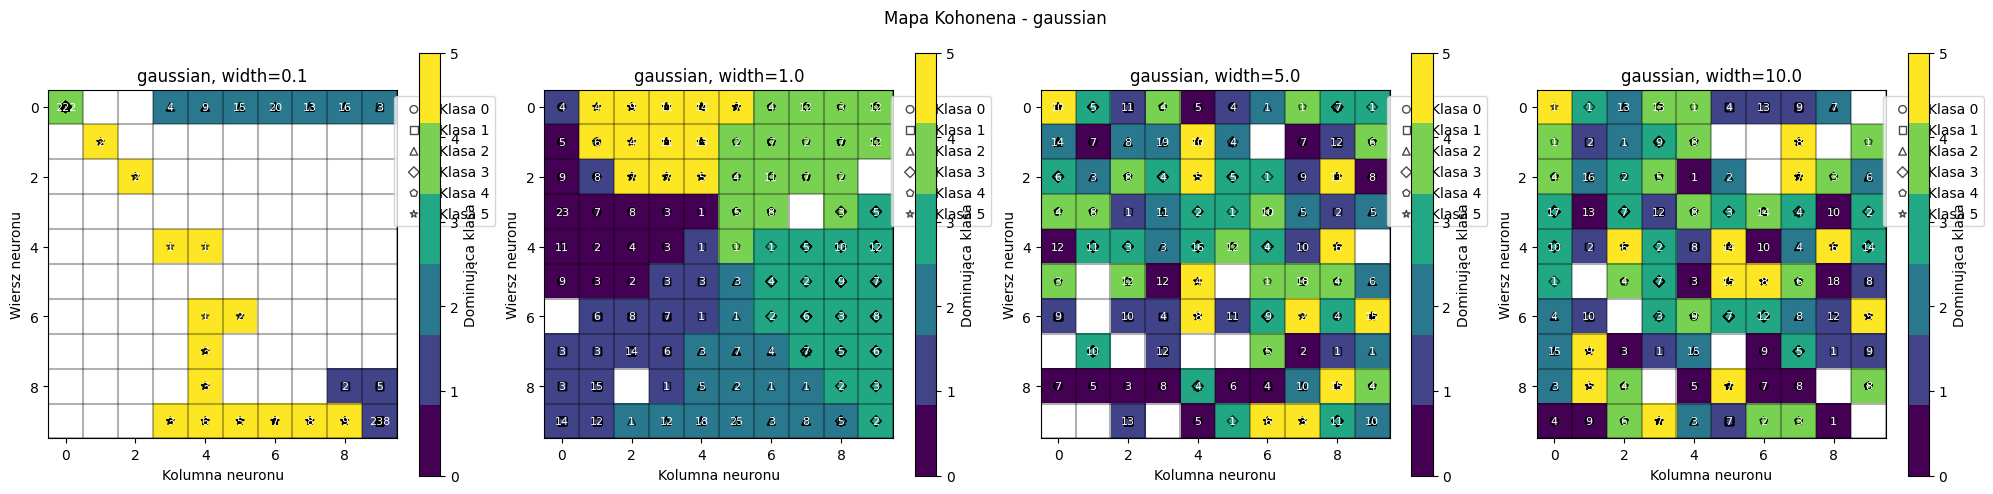

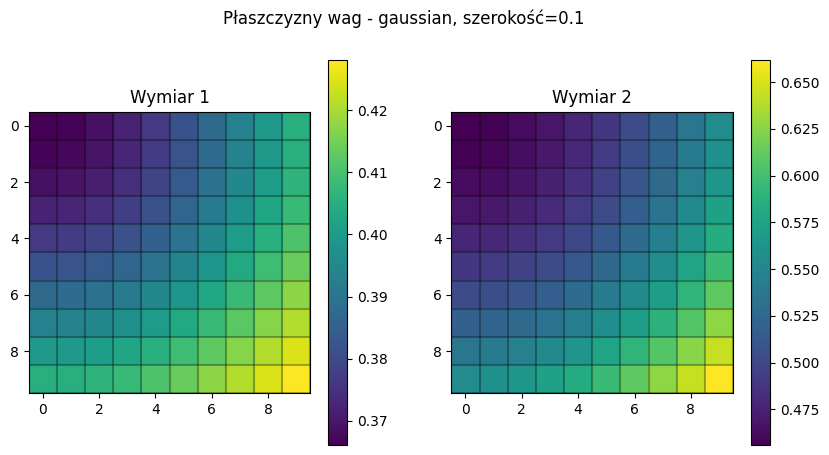

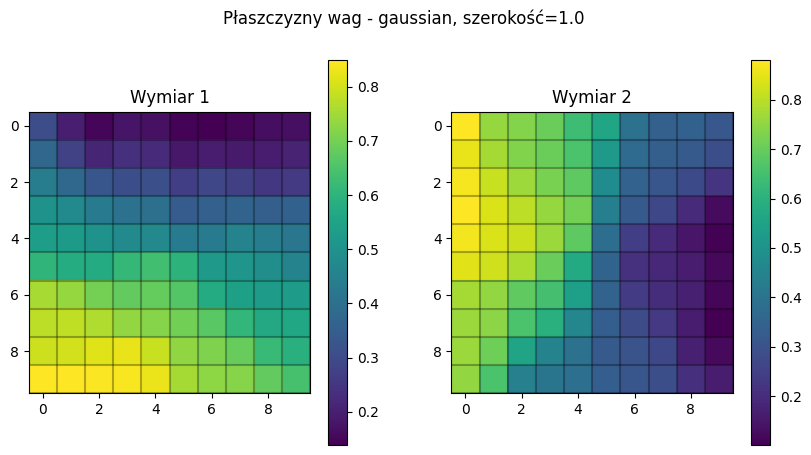

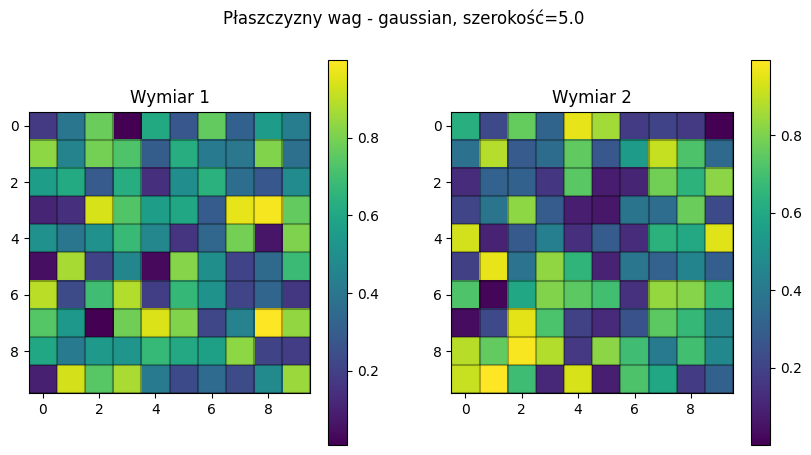

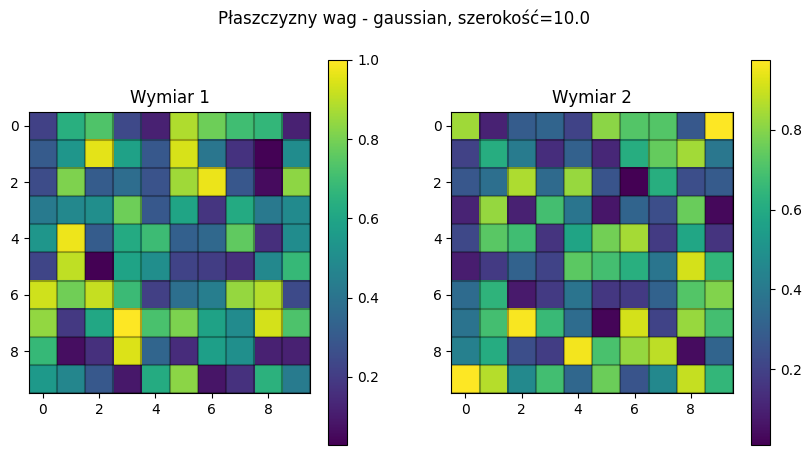

In [4]:
test_kohonen_network(
        data_path=hexagon_path,
        dimensions=2,
        grid_size=(10, 10),
        neighborhood_function='gaussian',
        neighborhood_widths=[0.1, 1.0, 5.0, 10.0],
        epochs=100
    )

Na podstawie powyższych wyników, można stwierdzić, że sieć Kohonena skutecznie grupuje dane w klastry - jest ich poprawna liczba - 5. W zależności od szerokości sąsiedztwa, neuronów z mieszanymi klasami jest mniej lub więcej. W przypadku szerokiego sąsiedztwa, sieć Kohonena może łączyć różne klasy w jeden klaster, natomiast dla wąskiego jak np. 1 widać dokładnie wydzielone klastry.

## Mexican Hat


Testowanie sieci z funkcją sąsiedztwa mexican_hat i szerokością 0.1


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 34.92epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


Liczba klastrów: 5
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 26.92%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [0.14 9.  ]
Klasa 1: [0.07 5.56]
Klasa 2: [7.39 0.04]
Klasa 3: [9.   0.64]
Klasa 4: [9.   7.67]
Klasa 5: [8.25 9.  ]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 2
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 2, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 1
  Czystość: 100.00%
Neuron (0, 4):
  Liczba próbek: 11
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 11, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 1
  Czystość: 100.00%
Neuron (0, 5):
  Liczba próbek: 28
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 28, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 1
  Czystość: 100.00%
Neuron (0, 6):
  Liczba

Trening sieci:  11%|█         | 11/100 [00:00<00:02, 36.13epoka/s]C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:41: RuntimeWarning: overflow encountered in square
  distances = np.sum((self.weights - x) ** 2, axis=2) # odległość euklidesowa
c:\nextcloud\Studia - PW\semestr 6\metody inteligencji obliczeniowej w analizie danych\H-_moje-github_sync-studia-Metody-inteligencji-obliczeniowej-w-analizie-danych\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Trening sieci:  23%|██▎       | 23/100 [00:00<00:02, 35.77epoka/s]C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:59: RuntimeWarning: overflow encountered in add
  self.weights += update
Trening sieci: 100%|██████████| 100/100 [00:03<00:00, 33.21epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 w

Liczba klastrów: 10
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 70.00%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [3.16 0.56]
Klasa 1: [1.14 2.66]
Klasa 2: [8.86 3.48]
Klasa 3: [8.85 7.07]
Klasa 4: [3.33 4.33]
Klasa 5: [5.27 4.78]

Wybrane statystyki neuronów:
Neuron (0, 3):
  Liczba próbek: 64
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 64, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 1
  Czystość: 100.00%
Neuron (0, 7):
  Liczba próbek: 34
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 34, np.int64(5): 0}
  Dominująca klasa: 4
  Czystość: 100.00%
Neuron (2, 0):
  Liczba próbek: 73
  Liczba próbek z poszczególnych klas: {np.int64(0): 72, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 1}
  Dominująca klasa: 0
  Czystość: 98.63%
Neuron (3, 2):
  Licz

Trening sieci: 100%|██████████| 100/100 [00:03<00:00, 32.77epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 7 Axes> than <Figure size 1000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 8.79%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [3.86 5.95]
Klasa 1: [4.92 4.24]
Klasa 2: [3.56 4.38]
Klasa 3: [4.45 3.69]
Klasa 4: [3.68 4.94]
Klasa 5: [4.42 5.35]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 4
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 4, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 1
  Czystość: 100.00%
Neuron (0, 1):
  Liczba próbek: 5
  Liczba próbek z poszczególnych klas: {np.int64(0): 5, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 0
  Czystość: 100.00%
Neuron (0, 2):
  Liczba próbek: 10
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 9, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 2
  Czystość: 90.00%
Neuron (0, 3):
  Liczba prób

Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 35.81epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 8 Axes> than <Figure size 1000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 9.89%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [5.11 5.3 ]
Klasa 1: [4.25 5.42]
Klasa 2: [4.24 4.95]
Klasa 3: [3.18 3.89]
Klasa 4: [2.79 4.46]
Klasa 5: [5.65 4.76]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 1
  Liczba próbek z poszczególnych klas: {np.int64(0): 1, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 0
  Czystość: 100.00%
Neuron (0, 1):
  Liczba próbek: 10
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 1, np.int64(3): 9, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 3
  Czystość: 90.00%
Neuron (0, 2):
  Liczba próbek: 1
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 1, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 3
  Czystość: 100.00%
Neuron (0, 3):
  Liczba prób

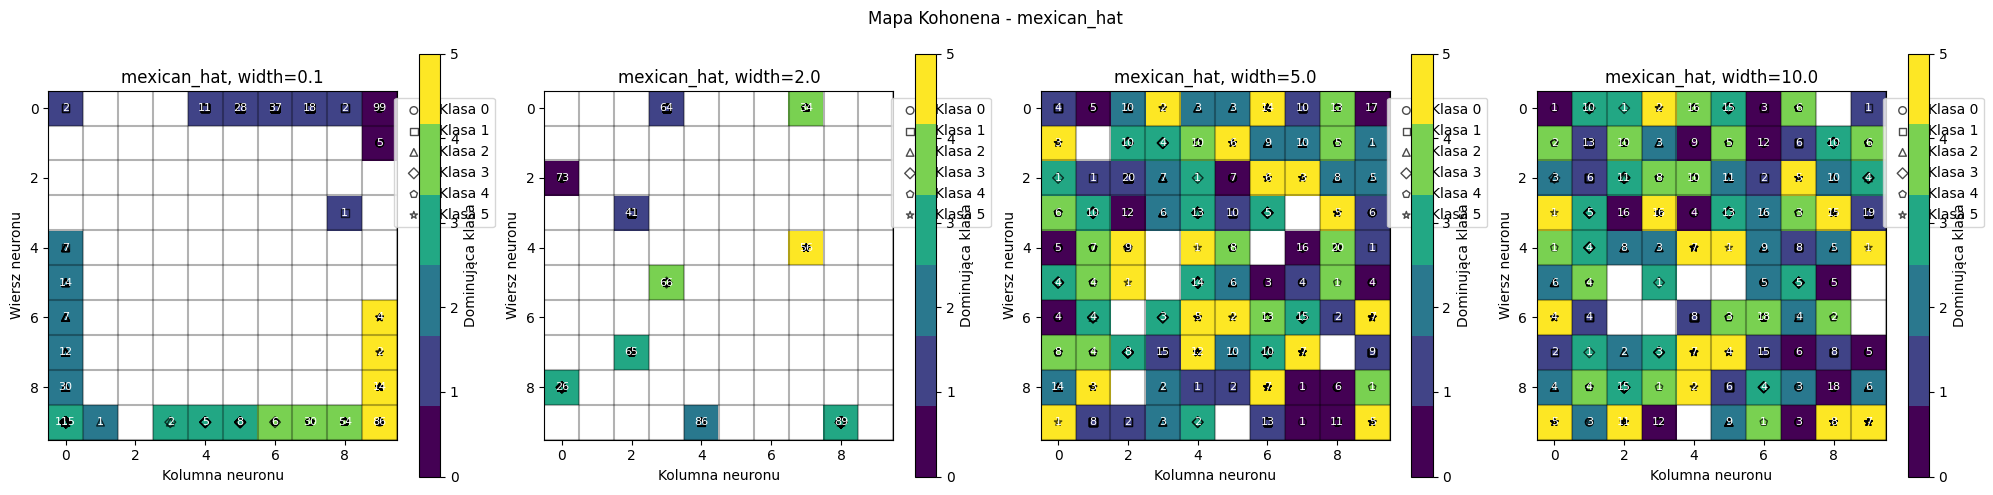

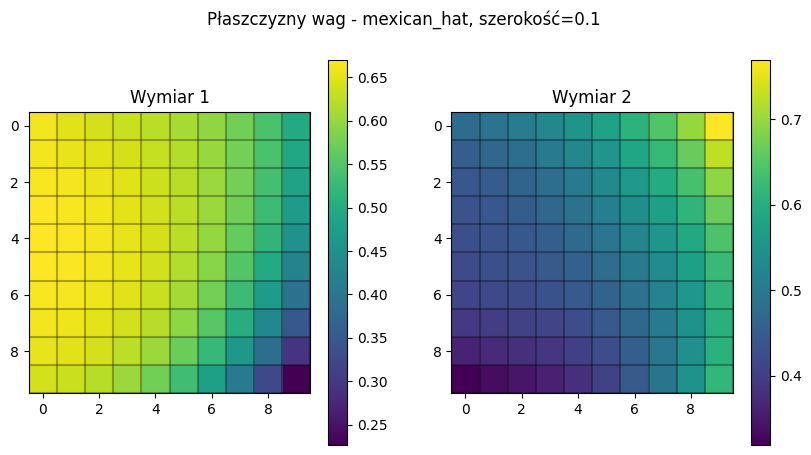

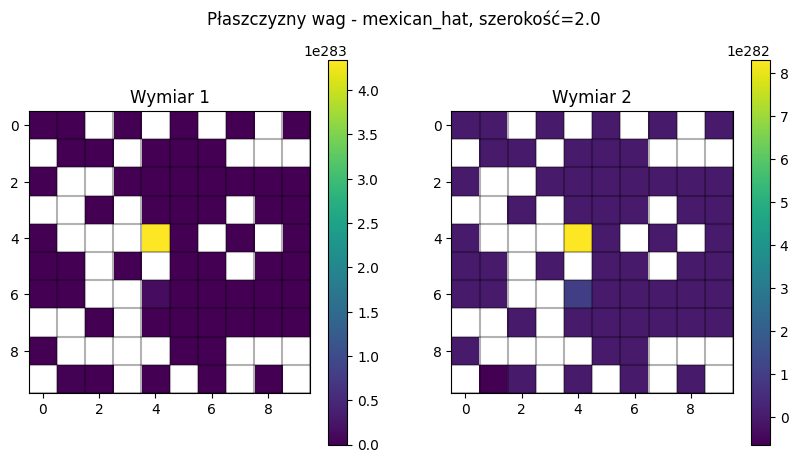

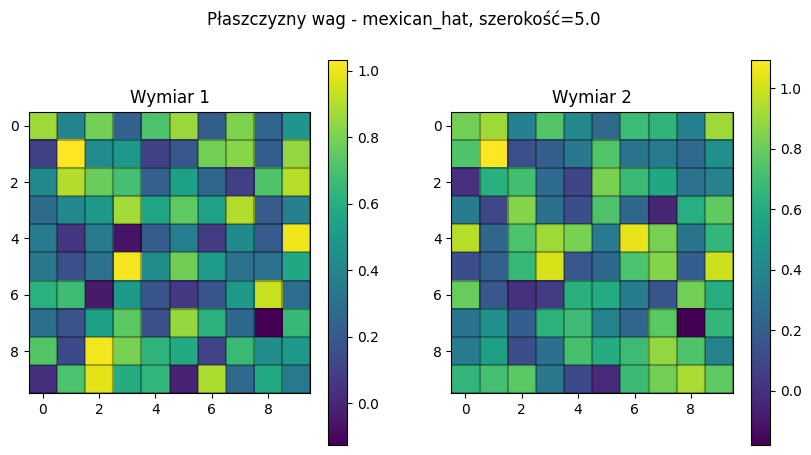

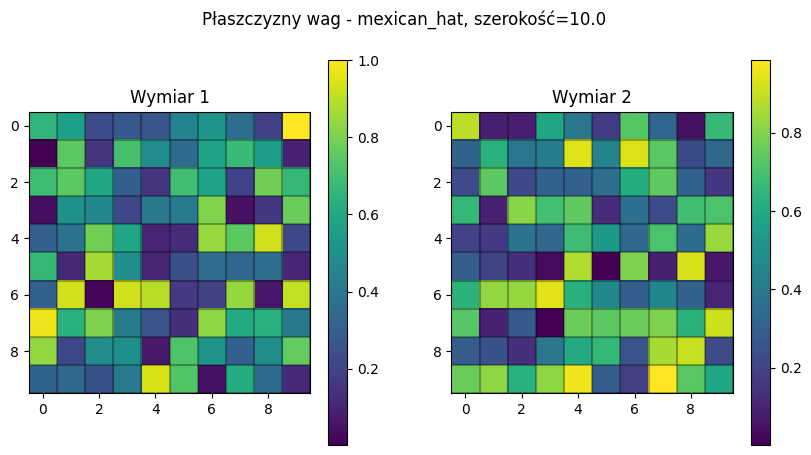

In [5]:
test_kohonen_network(
        data_path=hexagon_path,
        dimensions=2,
        grid_size=(10, 10),
        neighborhood_function='mexican_hat',
        neighborhood_widths=[0.1, 2.0, 5.0, 10.0],
        epochs=100
    )

## Cube

Text(0.5, 0.92, 'Dane 3D z klasami')

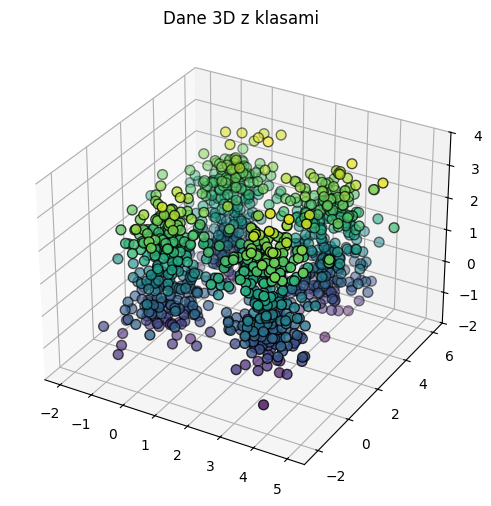

In [6]:
cube_path = "data/cube.csv"
data = pd.read_csv(cube_path, header=1).values
classes = data[:, 2]
data = data[:, :3]

# plot
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=classes, cmap='viridis', edgecolor='k', s=50)
plt.title("Dane 3D z klasami")

Jak widać na powyższym wykresie, dane są ułożone w sześcianie, problemem w klasyfikacji będzie użycie tylko 2 wymiarów - gdyż to ten trzeci (z) pozwala na wybór ostatecznej klasy.

### Gaussian


Testowanie sieci z funkcją sąsiedztwa gaussian i szerokością 0.1


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 38.63epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


Liczba klastrów: 8
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 25.93%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [0. 0.]
Klasa 1: [0.02 0.  ]
Klasa 2: [6.42 1.02]
Klasa 3: [8.68 8.95]
Klasa 4: [0.01 9.  ]
Klasa 5: [0.   6.48]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 230
  Liczba próbek z poszczególnych klas: {np.int64(0): 100, np.int64(1): 99, np.int64(2): 3, np.int64(3): 0, np.int64(4): 0, np.int64(5): 28}
  Dominująca klasa: 0
  Czystość: 43.48%
Neuron (0, 7):
  Liczba próbek: 1
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 1, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 2
  Czystość: 100.00%
Neuron (0, 9):
  Liczba próbek: 172
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 1, np.int64(4): 99, np.int64(5): 72}
  Dominująca klasa: 4
  Czystość: 57.56%
Neuron (1, 5):
  Liczba

Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 40.61epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 6 Axes> than <Figure size 1000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 8.79%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [2.01 7.41]
Klasa 1: [1.33 4.13]
Klasa 2: [2.64 0.54]
Klasa 3: [8.   0.74]
Klasa 4: [7.62 4.68]
Klasa 5: [6.6  8.59]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 4
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 4, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 2
  Czystość: 100.00%
Neuron (0, 1):
  Liczba próbek: 2
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 2, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 2
  Czystość: 100.00%
Neuron (0, 3):
  Liczba próbek: 5
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 5, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 1
  Czystość: 100.00%
Neuron (0, 4):
  Liczba prób

Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 39.18epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 7 Axes> than <Figure size 1000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 8.60%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [4.14 4.1 ]
Klasa 1: [4.79 3.78]
Klasa 2: [5.23 4.25]
Klasa 3: [3.51 4.94]
Klasa 4: [4.89 5.  ]
Klasa 5: [5.58 5.76]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 1
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 1, np.int64(5): 0}
  Dominująca klasa: 4
  Czystość: 100.00%
Neuron (0, 1):
  Liczba próbek: 3
  Liczba próbek z poszczególnych klas: {np.int64(0): 3, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 0
  Czystość: 100.00%
Neuron (0, 3):
  Liczba próbek: 8
  Liczba próbek z poszczególnych klas: {np.int64(0): 4, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 4}
  Dominująca klasa: 0
  Czystość: 50.00%
Neuron (0, 6):
  Liczba próbe

Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 37.43epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 8 Axes> than <Figure size 1000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 10.34%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [4.85 3.83]
Klasa 1: [5.79 3.11]
Klasa 2: [4.86 4.31]
Klasa 3: [3.26 4.09]
Klasa 4: [5.52 3.39]
Klasa 5: [4.6  4.91]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 4
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 4}
  Dominująca klasa: 5
  Czystość: 100.00%
Neuron (0, 1):
  Liczba próbek: 4
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 4, np.int64(5): 0}
  Dominująca klasa: 4
  Czystość: 100.00%
Neuron (0, 2):
  Liczba próbek: 14
  Liczba próbek z poszczególnych klas: {np.int64(0): 14, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 0
  Czystość: 100.00%
Neuron (0, 3):
  Liczba p

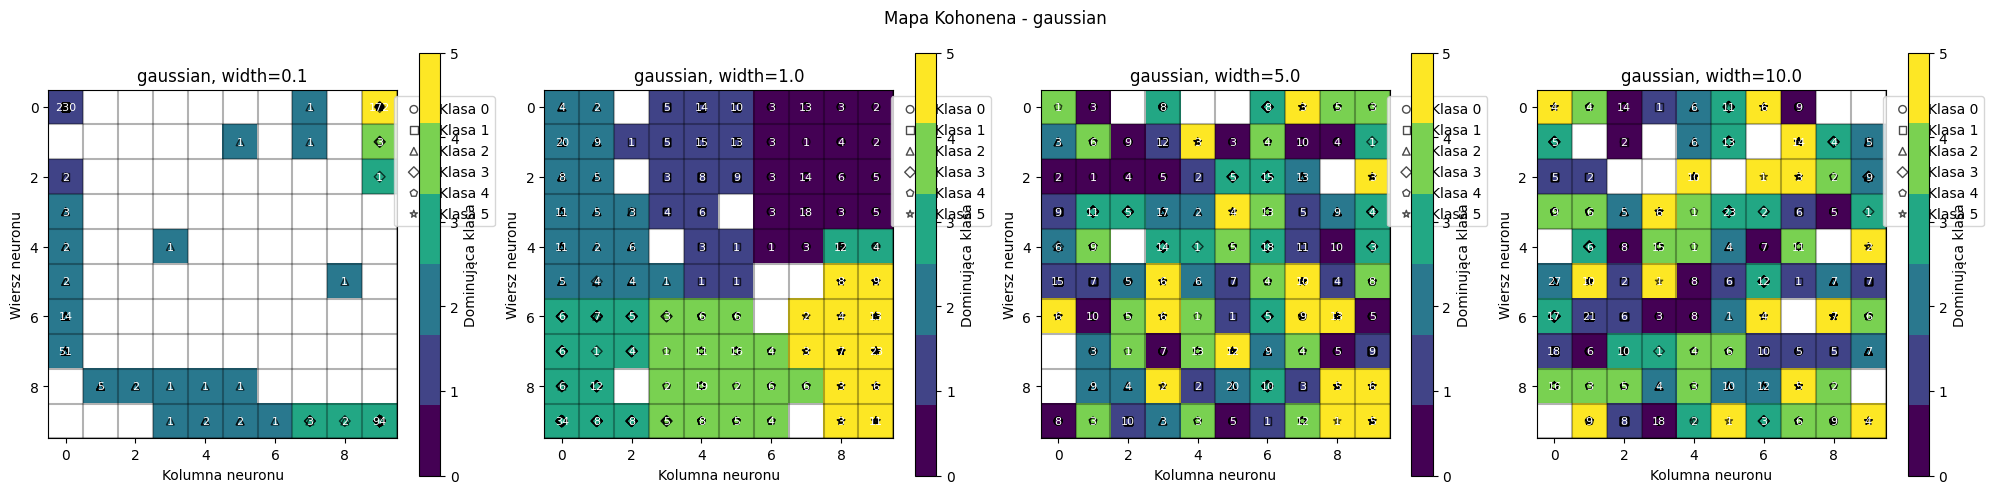

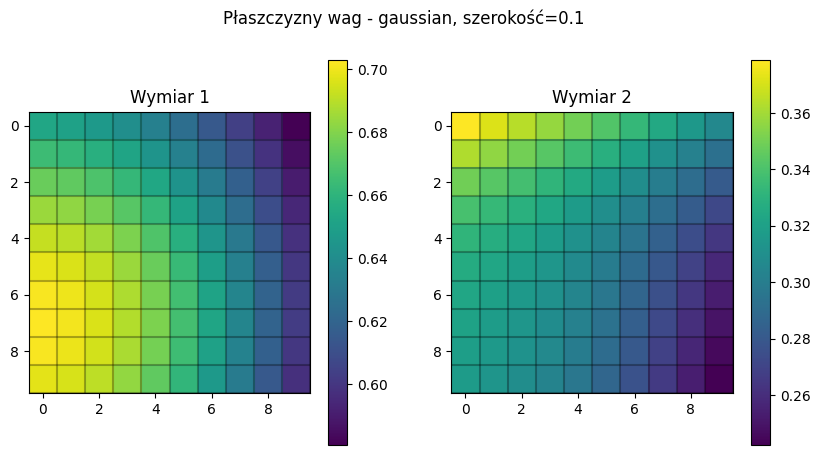

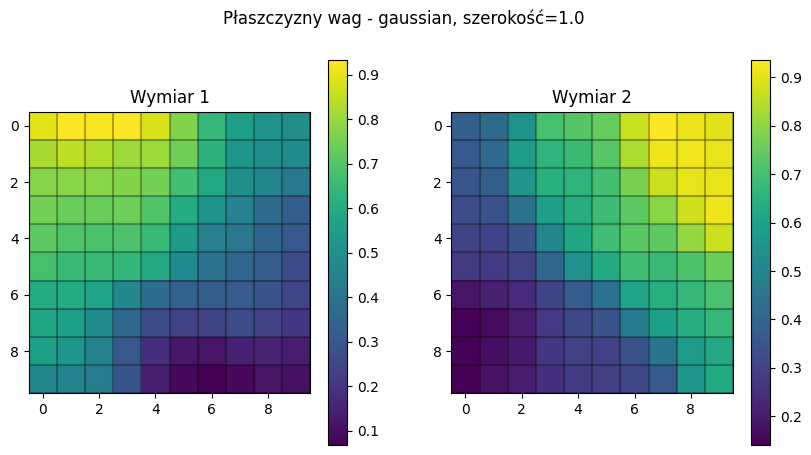

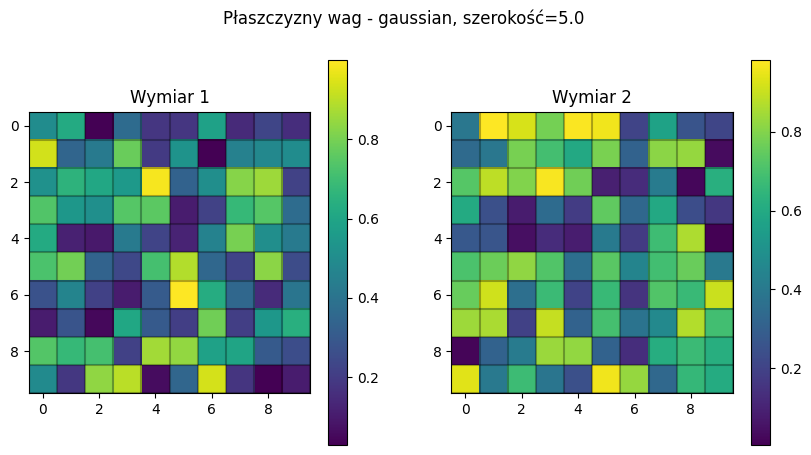

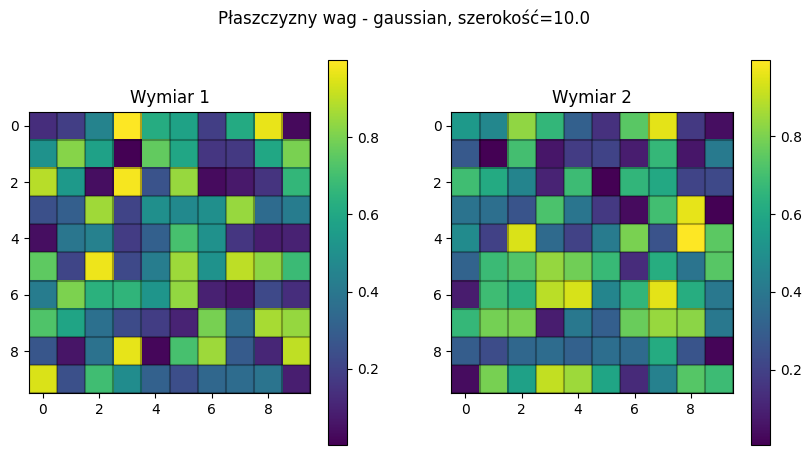

In [7]:
test_kohonen_network(
        data_path=hexagon_path,
        dimensions=2,
        grid_size=(10, 10),
        neighborhood_function='gaussian',
        neighborhood_widths=[0.1, 1.0, 5.0, 10.0],
        epochs=100
    )

## Mexican Hat


Testowanie sieci z funkcją sąsiedztwa mexican_hat i szerokością 0.1


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 37.32epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 10.96%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [1.13 1.53]
Klasa 1: [4.64 0.01]
Klasa 2: [8.  0.2]
Klasa 3: [9.  2.4]
Klasa 4: [6.3  5.74]
Klasa 5: [0.05 5.86]

Wybrane statystyki neuronów:
Neuron (0, 1):
  Liczba próbek: 2
  Liczba próbek z poszczególnych klas: {np.int64(0): 2, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 0
  Czystość: 100.00%
Neuron (0, 2):
  Liczba próbek: 9
  Liczba próbek z poszczególnych klas: {np.int64(0): 9, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 0
  Czystość: 100.00%
Neuron (0, 3):
  Liczba próbek: 16
  Liczba próbek z poszczególnych klas: {np.int64(0): 16, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 0
  Czystość: 100.00%
Neuron (0, 4):
  Liczba próbe

Trening sieci:   4%|▍         | 4/100 [00:00<00:02, 39.84epoka/s]C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:41: RuntimeWarning: overflow encountered in square
  distances = np.sum((self.weights - x) ** 2, axis=2) # odległość euklidesowa
c:\nextcloud\Studia - PW\semestr 6\metody inteligencji obliczeniowej w analizie danych\H-_moje-github_sync-studia-Metody-inteligencji-obliczeniowej-w-analizie-danych\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Trening sieci:   8%|▊         | 8/100 [00:00<00:02, 33.00epoka/s]C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:59: RuntimeWarning: overflow encountered in add
  self.weights += update
Trening sieci:  24%|██▍       | 24/100 [00:00<00:02, 34.38epoka/s]C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:58: RuntimeWarning: invalid value encountered in multiply
  update = learning_rate 

Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 100.00%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [3. 0.]
Klasa 1: [3. 0.]
Klasa 2: [3. 0.]
Klasa 3: [3. 0.]
Klasa 4: [3. 0.]
Klasa 5: [3. 0.]

Wybrane statystyki neuronów:
Neuron (3, 0):
  Liczba próbek: 600
  Liczba próbek z poszczególnych klas: {np.int64(0): 100, np.int64(1): 100, np.int64(2): 100, np.int64(3): 100, np.int64(4): 100, np.int64(5): 100}
  Dominująca klasa: 0
  Czystość: 16.67%

Testowanie sieci z funkcją sąsiedztwa mexican_hat i szerokością 5.0


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 36.47epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 7 Axes> than <Figure size 1000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 10.23%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [5.57 5.15]
Klasa 1: [3.8  4.75]
Klasa 2: [6.   5.95]
Klasa 3: [5.29 4.15]
Klasa 4: [2.63 5.18]
Klasa 5: [5.76 3.31]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 1
  Liczba próbek z poszczególnych klas: {np.int64(0): 1, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 0
  Czystość: 100.00%
Neuron (0, 1):
  Liczba próbek: 5
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 5, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 2
  Czystość: 100.00%
Neuron (0, 2):
  Liczba próbek: 8
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 8, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 1
  Czystość: 100.00%
Neuron (0, 3):
  Liczba pró

Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 34.93epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_34280\3319320021.py:101: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 8 Axes> than <Figure size 1000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


Liczba klastrów: 1
Liczba klas: 6
Czy liczba klastrów odpowiada liczbie klas: False
Procent neuronów z mieszanymi klasami: 8.99%

Średnie pozycje neuronów dla poszczególnych klas:
Klasa 0: [5.54 4.16]
Klasa 1: [3.38 5.96]
Klasa 2: [4.24 3.91]
Klasa 3: [4.67 4.79]
Klasa 4: [6.11 4.3 ]
Klasa 5: [3.43 5.36]

Wybrane statystyki neuronów:
Neuron (0, 0):
  Liczba próbek: 9
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 0, np.int64(3): 0, np.int64(4): 0, np.int64(5): 9}
  Dominująca klasa: 5
  Czystość: 100.00%
Neuron (0, 1):
  Liczba próbek: 4
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 4, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 2
  Czystość: 100.00%
Neuron (0, 2):
  Liczba próbek: 9
  Liczba próbek z poszczególnych klas: {np.int64(0): 0, np.int64(1): 0, np.int64(2): 9, np.int64(3): 0, np.int64(4): 0, np.int64(5): 0}
  Dominująca klasa: 2
  Czystość: 100.00%
Neuron (0, 3):
  Liczba prób

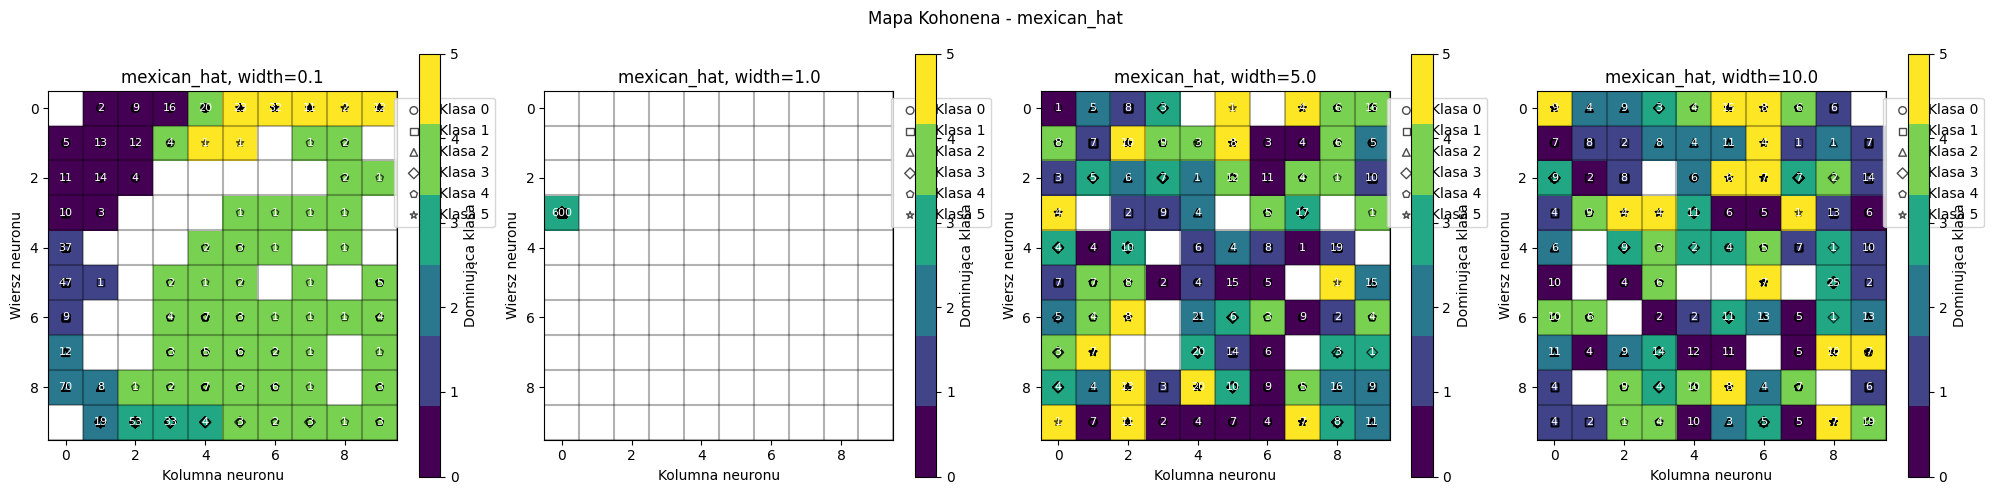

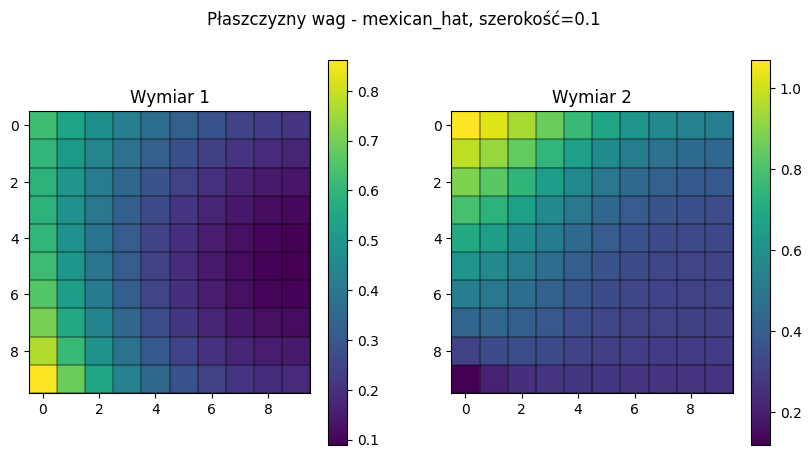

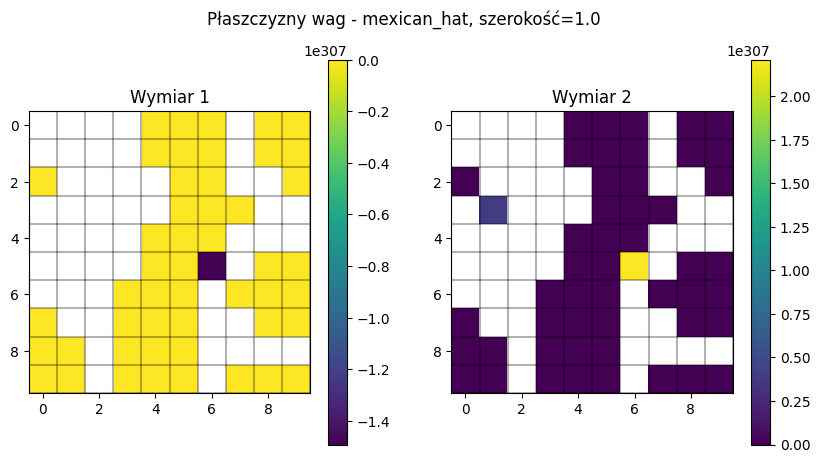

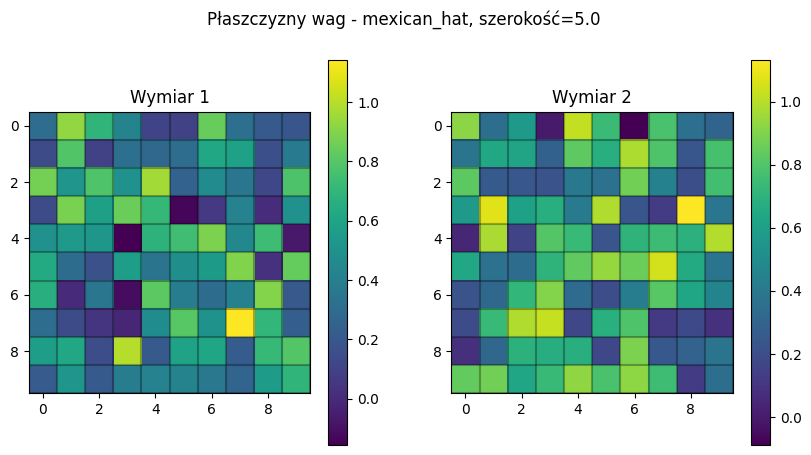

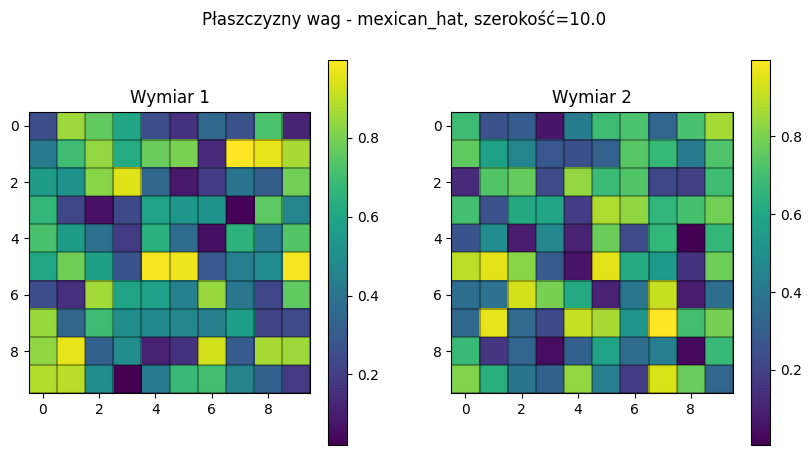

In [8]:
test_kohonen_network(
        data_path=hexagon_path,
        dimensions=2,
        grid_size=(10, 10),
        neighborhood_function='mexican_hat',
        neighborhood_widths=[0.1, 1.0, 5.0, 10.0],
        epochs=100
    )

Na podstawie poniższych wyników, można stwierdzić, że funkcja "mexican hat" radzi sobie lepiej w przypadku danych cube.